In [59]:
import autograd.numpy as np
import copy
from tqdm import tqdm
from autograd import elementwise_grad

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [83]:
def get_action(phi, k, l):
    return np.sum(-2 * k * phi * (np.roll(phi, 1, 0) + np.roll(phi, 1, 1))
                  + (1 - 2 * l) * phi**2 + l * phi**4)

def get_drift(phi, k, l):
    return (2 * k * (np.roll(phi, 1, 0) + np.roll(phi, -1, 0)
                     + np.roll(phi, 1, 1) + np.roll(phi, -1, 1))
            + 2 * phi * (2 * l * (1 - phi**2) - 1))

def get_hamiltonian(chi, action):
    return 0.5 * np.sum(chi**2) + action

def current_action(phi):
    return get_action(phi,1,1)

get_action_grad = elementwise_grad(get_action)

In [82]:
get_action_grad(phi,k,l)

array([[ 0.38957749,  1.0729675 ,  1.00054859, ...,  0.77692629,
         0.73948747,  0.3440029 ],
       [-0.36902853, -2.04923207, -0.4565891 , ..., -2.23635608,
         3.42814695,  1.36720652],
       [-0.01294658,  1.66599162,  0.81488497, ..., -1.24683462,
        -3.06813523,  1.04501729],
       ...,
       [ 1.03865786,  0.22625152, -1.44868516, ...,  1.83755799,
         2.66692579,  1.10029058],
       [-0.90573119, -2.81472248,  1.68557834, ..., -1.4285339 ,
        -5.13290289,  3.0933839 ],
       [ 0.33056245,  0.99563509,  3.75033015, ..., -1.27657473,
         1.53484012,  0.0445339 ]])

In [73]:
def hmc(phi_0, S_0, k, l, n_steps=100):
    dt = 1 / n_steps

    phi = phi_0
    chi = np.random.randn(*phi.shape)
    H_0 = get_hamiltonian(chi, S_0)

    chi += 0.5 * dt * get_drift(phi, k, l)
    for i in range(n_steps-1):
        phi += dt * chi
        chi -= dt * get_action_grad(phi, k, l)
    phi += dt * chi
    chi += 0.5 * dt * get_drift(phi, k, l)

    S = get_action(phi, k, l)
    dH = get_hamiltonian(chi, S) - H_0

    if dH > 0:
        if np.random.rand() >= np.exp(-dH):
            return phi_0, S_0, False
    return phi, S, True

In [70]:
L = 32
k = 0.3
l = 0.02

phi = np.random.randn(L,L)
S = get_action(phi, k, l)

In [48]:
get_action(phi, 1, 2)

2203.76619055916

In [49]:
get_action_2(phi).shape

(32, 32)

In [72]:
get_action_grad(phi,k,l)

array([[-0.03725215, -0.64685295,  0.82265174, ..., -0.64714611,
         0.31859935,  1.54387716],
       [-0.44799597, -1.9058887 ,  1.88256238, ..., -1.15494848,
         0.92863015,  0.86711151],
       [ 1.11916673, -0.72405492,  0.53683863, ..., -1.43018271,
        -4.00484668, -0.5427426 ],
       ...,
       [ 1.29307605,  1.36697425, -1.42747103, ...,  1.62638924,
        -0.21273222, -2.49358609],
       [ 0.31921113, -3.07040101,  2.12849436, ..., -2.55457178,
        -1.34999648,  3.51027633],
       [-3.50175229,  1.92835474,  2.31616756, ...,  2.57902566,
         0.7077184 , -1.37841969]])

In [71]:
get_drift(phi,k,l)

array([[ 0.03725215,  0.64685295, -0.82265174, ...,  0.64714611,
        -0.31859935, -1.54387716],
       [ 0.44799597,  1.9058887 , -1.88256238, ...,  1.15494848,
        -0.92863015, -0.86711151],
       [-1.11916673,  0.72405492, -0.53683863, ...,  1.43018271,
         4.00484668,  0.5427426 ],
       ...,
       [-1.29307605, -1.36697425,  1.42747103, ..., -1.62638924,
         0.21273222,  2.49358609],
       [-0.31921113,  3.07040101, -2.12849436, ...,  2.55457178,
         1.34999648, -3.51027633],
       [ 3.50175229, -1.92835474, -2.31616756, ..., -2.57902566,
        -0.7077184 ,  1.37841969]])

In [65]:
get_action_grad(phi,k,l).shape

(32, 32)

In [74]:
for _ in tqdm(range(1000)):
    phi, S, accepted = hmc(phi, S, k, l)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.87it/s]


In [75]:
cfgs = []

for i in tqdm(range(10000)):
    phi, S, accepted = hmc(phi, S, k, l)
    
    if i % 10 == 0:
        cfgs.append(copy.deepcopy(phi))
        
cfgs = np.array(cfgs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:26<00:00, 22.39it/s]


In [76]:
def jackknife(samples: np.ndarray):
    """Return mean and estimated lower error bound."""
    means = []

    for i in range(samples.shape[0]):
        means.append(np.delete(samples, i, axis=0).mean(axis=0))

    means = np.asarray(means)
    mean = means.mean(axis=0)
    error = np.sqrt((samples.shape[0] - 1) * np.mean(np.square(means - mean), axis=0))
    
    return mean, error

In [77]:
def get_mag(cfgs: np.ndarray):
    """Return mean and error of magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(cfgs.mean(axis=axis))

def get_abs_mag(cfgs: np.ndarray):
    """Return mean and error of absolute magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(np.abs(cfgs.mean(axis=axis)))

def get_chi2(cfgs: np.ndarray):
    """Return mean and error of suceptibility."""
    V = np.prod(cfgs.shape[1:])
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    mags = cfgs.mean(axis=axis)
    return jackknife(V * (mags**2 - mags.mean()**2))

def get_corr_func(cfgs: np.ndarray):
    """Return connected two-point correlation function with errors for symmetric lattices."""
    mag_sq = np.mean(cfgs)**2
    corr_func = []
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])

    for i in range(1, cfgs.shape[1], 1):
        corrs = []

        for mu in range(len(cfgs.shape)-1):
            corrs.append(np.mean(cfgs * np.roll(cfgs, i, mu+1), axis=axis))

        corrs = np.array(corrs).mean(axis=0)
        corr_mean, corr_err = jackknife(corrs - mag_sq)
        corr_func.append([i, corr_mean, corr_err])

    return np.array(corr_func)

In [78]:
M, M_err = get_mag(cfgs)
M_abs, M_abs_err = get_abs_mag(cfgs)
chi2, chi2_err = get_chi2(cfgs)

print("M = %.4f +/- %.4f" % (M, M_err))
print("|M| = %.4f +/- %.4f" % (M_abs, M_abs_err))
print("chi2 = %.4f +/- %.4f" % (chi2, chi2_err))

M = -2.1961 +/- 0.0013
|M| = 2.1961 +/- 0.0013
chi2 = 1.6196 +/- 5.6524


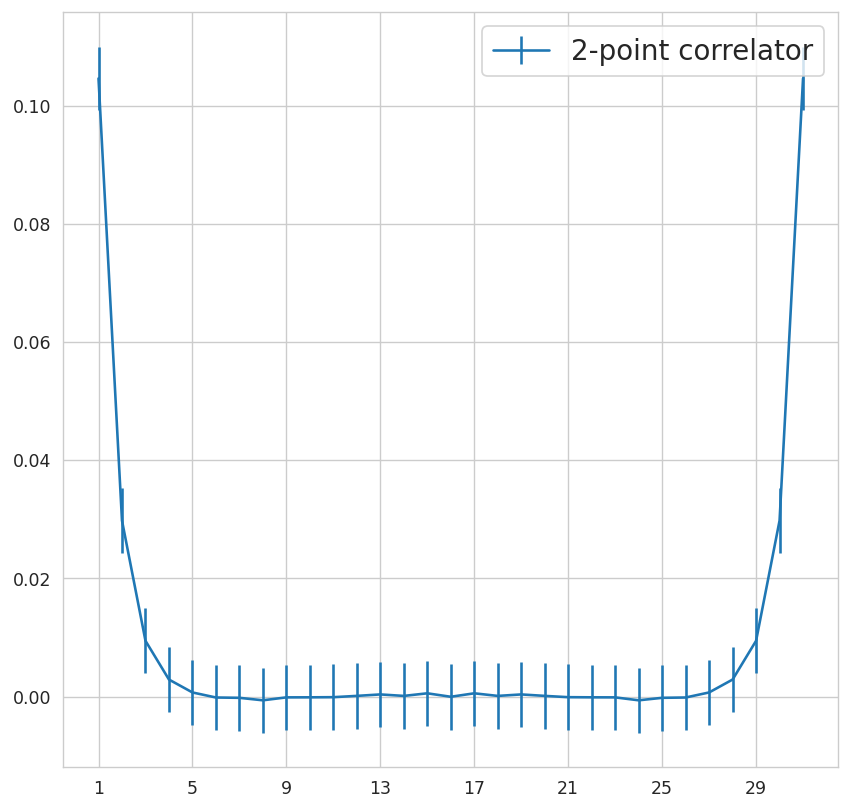

In [79]:
corr_func = get_corr_func(cfgs)

fig, ax = plt.subplots(1,1, dpi=125, figsize=(8,8))
plt.xticks([i for i in range(1, L, 4)])
ax.errorbar(corr_func[:,0], corr_func[:,1], yerr=corr_func[:,2], label='2-point correlator')
plt.legend(prop={'size': 16})
plt.show()